# Music Recommender (Python 2, GraphLab)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from time import time

% matplotlib inline

# plt.style.use("ggplot")

In [3]:
df_rec_final = pd.read_csv('../data/df_rec_final.csv')

### Down sample by uid
too many records here. run out of memory.

In [45]:
users = df_rec_final['uid'].unique()

users.shape

(57898,)

In [89]:
selected_users = np.random.choice(users, size=2500, replace=False).tolist()

df_rec = df_rec_final[df_rec_final['uid'].isin(selected_users)]

df_rec.shape

(127468, 5)

In [90]:
df_rec.reset_index(inplace=True, drop=True)

In [91]:
df_rec['rating'] = np.where(df_rec['rela_freq_last_44']==0, 1, 
                           np.where(df_rec['rela_freq_last_44']==1, 2,
                                   np.where(df_rec['rela_freq_last_44']<3, 3, 
                                           np.where(df_rec['rela_freq_last_44']<5, 4, 5))))

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


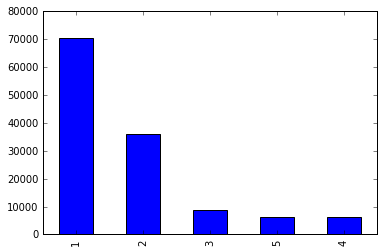

In [92]:
df_rec['rating'].value_counts().plot.bar()

In [93]:
df_rec = df_rec[['uid', 'song_id', 'rating']]

df_rec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127468 entries, 0 to 127467
Data columns (total 3 columns):
uid        127468 non-null int64
song_id    127468 non-null int64
rating     127468 non-null int64
dtypes: int64(3)
memory usage: 2.9 MB


In [94]:
df_utility = pd.pivot_table(data=df_rec,
                           values='rating',
                           index='uid',
                           columns='song_id',
                           fill_value=0)

In [95]:
uid_list = df_utility.index

uid_list.shape

(2500,)

In [96]:
item_id_list = df_utility.columns

item_id_list.shape

(55323,)

In [97]:
df_utility.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 3346080 to 169146102
Columns: 55323 entries, 2065 to 24022934
dtypes: int64(55323)
memory usage: 1.0 GB


# Recommender system with GraphLab

## Item-item recommender 

In [98]:
import graphlab

In [99]:
sf_stars = graphlab.SFrame(df_rec)

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1544181353.log


This non-commercial license of GraphLab Create for academic use is assigned to zhan716@usc.edu and will expire on August 22, 2019.


In [100]:
sf_stars

uid,song_id,rating
3346080,20876508,1
7466984,871878,2
7466984,2843083,3
17595990,1014338,1
24429362,703912,2
24429362,3251191,5
54655075,15249349,2
99651190,4019405,1
130420955,157612,1
132279304,9913756,1


In [102]:
# item-item recommender
item_item_rec = graphlab.recommender.item_similarity_recommender.create(sf_stars,
                                                                        user_id='uid',
                                                                        item_id='song_id',
                                                                        target = 'rating')

Recsys training: model = item_similarity

Preparing data set.

Data has 127468 observations with 2500 users and 55323 items.

Data prepared in: 0.201483s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 5.61ms                         | 40         |

| 7.397ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in 2 passes using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 7.96s                               | 0                | 12              |

| 8.97s                               | 7.25             | 4030            |

| 9.97s                               | 10.75            | 6045            |

| 10.97s                              | 15.5             | 8626            |

| 11.97s                              | 23.25            | 12979           |

| 12.98s                              | 29               | 16050           |

| 13.97s                              | 35.25            | 19592           |

| 14.98s                              | 42.25            | 23510           |

| 15.98s                              | 49               | 27172           |

| 1m 1s                               | 50               | 27673           |

| 1m 13s                              | 100              | 55323           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 75.1522s

In [103]:
# For every user, recommend top 3 songs
item_item_rec_result = item_item_rec.recommend(k=5, verbose=False)
item_item_rec_result

uid,song_id,score,rank
3346080,2784869,0.0456790123825,1
3346080,2464362,0.0456790123825,2
3346080,1754476,0.0436507932566,3
3346080,1889855,0.04074074052,4
3346080,288568,0.0398148143733,5
7466984,7167333,0.0251088521697,1
7466984,7152046,0.0243377991539,2
7466984,7169672,0.0228612684311,3
7466984,7149811,0.0226043083451,4
7466984,7130624,0.0225126851689,5


## Popularity-based Recommender

In [104]:
# build recommendation system
pop_rec = graphlab.popularity_recommender.create(sf_stars, 
                                                 user_id = 'uid', 
                                                 item_id = 'song_id',
                                                 target = 'rating')

Recsys training: model = popularity

Preparing data set.

Data has 127468 observations with 2500 users and 55323 items.

Data prepared in: 0.237846s

127468 observations to process; with 55323 unique items.

In [105]:
# get recommendation
pop_result = pop_rec.recommend()

recommendations finished on 1000/2500 queries. users per second: 3507.59

recommendations finished on 2000/2500 queries. users per second: 2975.84

In [106]:
pop_result.print_rows(num_rows=30)

+----------+----------+-------+------+
|   uid    | song_id  | score | rank |
+----------+----------+-------+------+
| 3346080  | 5755277  |  5.0  |  1   |
| 3346080  | 9327365  |  5.0  |  2   |
| 3346080  | 1013750  |  5.0  |  3   |
| 3346080  | 4405668  |  5.0  |  4   |
| 3346080  | 7153606  |  5.0  |  5   |
| 3346080  | 1037101  |  5.0  |  6   |
| 3346080  | 1106011  |  5.0  |  7   |
| 3346080  | 22857491 |  5.0  |  8   |
| 3346080  | 1067925  |  5.0  |  9   |
| 3346080  | 9560599  |  5.0  |  10  |
| 7466984  | 5755277  |  5.0  |  1   |
| 7466984  | 9327365  |  5.0  |  2   |
| 7466984  | 1013750  |  5.0  |  3   |
| 7466984  | 4405668  |  5.0  |  4   |
| 7466984  | 7153606  |  5.0  |  5   |
| 7466984  | 1037101  |  5.0  |  6   |
| 7466984  | 1106011  |  5.0  |  7   |
| 7466984  | 22857491 |  5.0  |  8   |
| 7466984  | 1067925  |  5.0  |  9   |
| 7466984  | 9560599  |  5.0  |  10  |
| 17595990 | 5755277  |  5.0  |  1   |
| 17595990 | 9327365  |  5.0  |  2   |
| 17595990 | 1013750  |  

## Matrix Factorization Recommender

In [107]:
# build the MF model
rec = graphlab.recommender.factorization_recommender.create(
            sf_stars,
            user_id='uid',
            item_id='song_id',
            target='rating',
            solver='als',
            side_data_factorization=False)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 127468 observations with 2500 users and 55323 items.

Data prepared in: 0.184917s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 8        |

| regularization               | L2 Regularization on Factors                     | 1e-08    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 132us        | NA                     |

+---------+--------------+------------------------+

| 0       | 157.851ms    | 0.482652               |

| 1       | 294.711ms    | 0.416217               |

| 2       | 470.3ms      | 0.387703               |

| 3       | 671.457ms    | 0.36937                |

| 4       | 829.594ms    | 0.356102               |

| 5       | 971.85ms     | 0.346219               |

| 6       | 1.16s        | 0.338409               |

| 7       | 1.37s        | 0.332112               |

| 8       | 1.50s        | 0.32697                |

| 9       | 1.63s        | 0.322631               |

| 10      | 1.78s        | 0.318929               |

| 11      | 1.92s        | 0.315717               |

| 12      | 2.07s        | 0.312887               |

| 13      | 2.20s        | 0.310375               |

| 14      | 2.38s        | 0.308116               |

| 15      | 2.60s        | 0.306074               |

| 16      | 2.73s        | 0.304184               |

| 17      | 2.97s        | 0.302445               |

| 18      | 3.27s        | 0.300841               |

| 19      | 3.45s        | 0.299353               |

| 20      | 3.64s        | 0.297958               |

| 21      | 3.78s        | 0.296651               |

| 22      | 3.91s        | 0.295419               |

| 23      | 4.05s        | 0.294263               |

| 24      | 4.18s        | 0.293176               |

| 25      | 4.31s        | 0.292156               |

| 26      | 4.46s        | 0.2912                 |

| 27      | 4.59s        | 0.290301               |

| 28      | 4.74s        | 0.289453               |

| 29      | 4.87s        | 0.288652               |

| 30      | 5.00s        | 0.287891               |

| 31      | 5.13s        | 0.287151               |

| 32      | 5.26s        | 0.286446               |

| 33      | 5.39s        | 0.285776               |

| 34      | 5.52s        | 0.285136               |

| 35      | 5.65s        | 0.284521               |

| 36      | 5.78s        | 0.283927               |

| 37      | 5.91s        | 0.283341               |

| 38      | 6.04s        | 0.282795               |

| 39      | 6.18s        | 0.282273               |

| 40      | 6.31s        | 0.281769               |

| 41      | 6.44s        | 0.281282               |

| 42      | 6.57s        | 0.28081                |

| 43      | 6.70s        | 0.280353               |

| 44      | 6.83s        | 0.279913               |

| 45      | 6.96s        | 0.279486               |

| 46      | 7.10s        | 0.279069               |

| 47      | 7.22s        | 0.278663               |

| 48      | 7.35s        | 0.278269               |

| 49      | 7.48s        | 0.277879               |

| FINAL   | 7.48s        | 0.277879               |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

###  See the prediction rating for a user on a song 

In [109]:
one_datapoint_sf = graphlab.SFrame({'uid': [sf_stars['uid'][0]], 'song_id': [sf_stars['song_id'][10]]}) 
one_datapoint_sf

song_id,uid
6461990,3346080


In [110]:
print "rating for datapoint\n", one_datapoint_sf, "\n:", rec.predict(one_datapoint_sf)[0] 

rating for datapoint
+---------+---------+
| song_id |   uid   |
+---------+---------+
| 6461990 | 3346080 |
+---------+---------+
[1 rows x 2 columns]
 
: 2.36272055157


In [112]:
# For a specic user
rec.recommend(users=[sf_stars['uid'][0]], k=10)

uid,song_id,score,rank
3346080,292491,101.010132256,1
3346080,101388,81.1492466355,2
3346080,23536983,76.0493397141,3
3346080,684594,73.3662342454,4
3346080,900826,59.3152164841,5
3346080,707536,58.801483574,6
3346080,508066,58.8012279893,7
3346080,10901542,57.0044369126,8
3346080,123138,52.9487957383,9
3346080,691218,52.1415867234,10


### Training Root Mean Squared Error

In [114]:
print "The training rmse:", rec['training_rmse']

The training rmse: 0.277879101015


### Regularization Method for MF Recommender 

In [115]:
random_seed = 0
regularization_param = 10
rec_regularized = graphlab.recommender.factorization_recommender.create(
                    sf_stars,
                    user_id='uid',
                    item_id='song_id',
                    target='rating',
                    solver='als',
                    side_data_factorization=False,
                    regularization=regularization_param,
                    random_seed=random_seed,
                    verbose=False) 
print "training rmse with regularization %s:"%regularization_param, rec_regularized['training_rmse']

Recsys training: model = factorization_recommender

training rmse with regularization 10: 1.09093221346


## Model Tune via Cross-validation
<font color = red>
However, as we can see, the training rmse above is very small, it is very likely for them to suffer a serious over-fitting problem.

In [116]:
kfolds = graphlab.cross_validation.KFold(sf_stars, 5)

params = dict(user_id='uid', 
              item_id='song_id', 
              target='rating',
              solver='als', 
              side_data_factorization=False)

paramsearch = graphlab.model_parameter_search.create(
                    kfolds,
                    graphlab.recommender.factorization_recommender.create,
                    params)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.job: Creating a LocalAsync environment called 'async'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Dec-07-2018-03-25-4100000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Dec-07-2018-03-25-4100000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Dec-07-2018-03-25-4100000' already exists. Renaming the job to 'Model-Parameter-Search-Dec-07-2018-03-25-4100000-ec9e2'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Dec-07-2018-03-25-41000

In [117]:
best_params = paramsearch.get_best_params('mean_validation_rmse', ascending=True)
best_params

{'item_id': 'song_id',
 'linear_regularization': 1e-07,
 'max_iterations': 50,
 'num_factors': 64,
 'regularization': 0.0001,
 'side_data_factorization': False,
 'solver': 'als',
 'target': 'rating',
 'user_id': 'uid'}

In [118]:
results_df = paramsearch.get_results().to_dataframe()
results_df_sorted = results_df.sort_values('mean_validation_rmse')
print 'The params of the best model are: \n', best_params, \
       '\n The mean training rmse is: \n %s'%results_df_sorted['mean_training_rmse'].iloc[0], \
       '\n The mean validation rmse is: \n %s'%results_df_sorted['mean_validation_rmse'].iloc[0]

The params of the best model are: 
{'side_data_factorization': False, 'regularization': 0.0001, 'user_id': 'uid', 'target': 'rating', 'solver': 'als', 'num_factors': 64, 'item_id': 'song_id', 'max_iterations': 50, 'linear_regularization': 1e-07} 
 The mean training rmse is: 
 0.7428056812120007 
 The mean validation rmse is: 
 1.0274712323770883


After tuning the model we finally acquire is fairly robust. 